In [1]:
import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import matplotlib.pyplot as plt

In [9]:
def watershed_segmentation(img, show_image = False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    filtro = cv2.pyrMeanShiftFiltering(img, 20, 40)
    gray = cv2.cvtColor(filtro, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    if show_image:
        contornos, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        buracos = []
        for con in contornos:
            area = cv2.contourArea(con)
            if area < 1000:
                buracos.append(con)
        cv2.drawContours(thresh, buracos, -1, 255, -1)
        dist = ndi.distance_transform_edt(thresh)
        dist_visual = dist.copy()
        local_max = peak_local_max(dist, indices=False, min_distance=20, labels=thresh)

        markers = ndi.label(local_max, structure=np.ones((3, 3)))[0]

        labels = watershed(-dist, markers, mask=thresh)
        titulos = ['Original image', 'Binary Image', 'Distance Transform', 'Watershed']
        imagens = [img, thresh, dist_visual, labels]
        fig = plt.gcf()
        fig.set_size_inches(16, 12)  
        for i in range(4):
            plt.subplot(2,2,i+1)
            if (i == 3):
                cmap = "jet"
            else:
                cmap = "gray"
            plt.imshow(imagens[i], cmap)
            plt.title(titulos[i]) 
            plt.xticks([]),plt.yticks([])     
        plt.show()
        
    return thresh

/tmp/ipykernel_61892/2073076285.py:17: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(dist, indices=False, min_distance=20, labels=thresh)


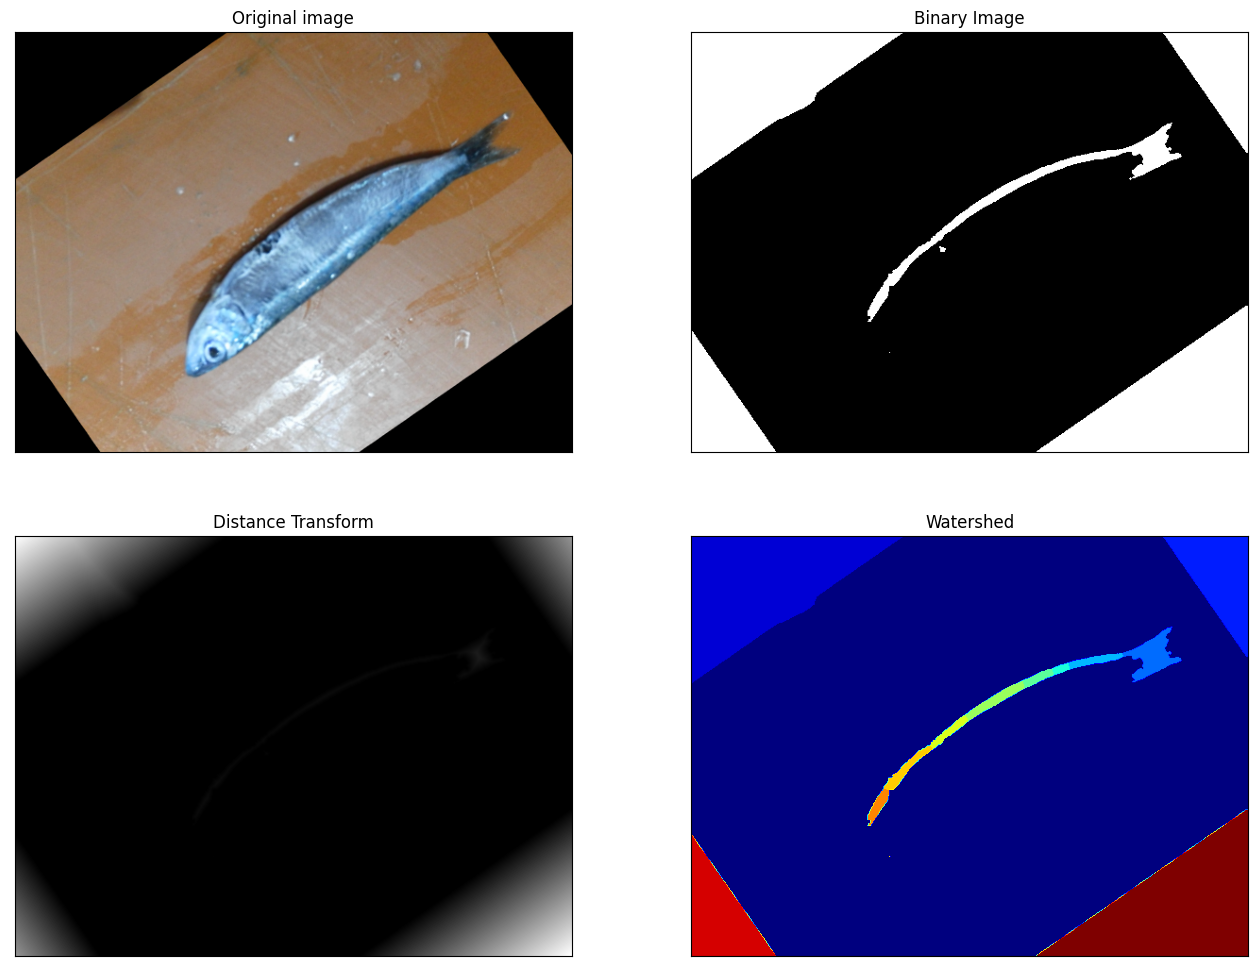

In [10]:
img = cv2.imread('./final_dataset/images/img_0.png')

thresh = watershed_segmentation(img, True)

In [ ]:
org_msk_img = cv2.imread('mask0.jpeg')
org_msk_img = cv2.cvtColor(org_msk_img, cv2.COLOR_BGR2GRAY)